In [1]:
import pandas as pd
import os
import re
import spacy
import numpy as np
from tqdm import tqdm
tqdm.pandas()
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
nlp = spacy.load("en_core_web_lg")

def word_count(s):
    return len(s.split())

def get_models_list():
    return [x[:-4] for x in os.listdir("ig_features") if x.endswith(".csv")]

def get_model_df(method, model_name):
    df = pd.read_csv(os.path.join(method + "_features", f"{model_name}.csv"), sep="\t")
    return df

def add_word_count_to_df(df):
    df["word_count"] = df["original_sent"].apply(lambda s: word_count(s))
    return df

_bins = [0.0, 10.0, 15.0, 20.0, 25.0, 30.0, 40.0, np.inf]
_labels = [1, 2, 3, 4, 5, 6, 7]
def bin_num_to_label(num):
    if _bins[num] == np.inf:
        # return f"sentence_length >= {int(_bins[num-1])}"
        return f">{int(_bins[num-1])}"
    else:
        return f"{int(_bins[num-1])}-{int(_bins[num])}"

def add_bin_number_to_df(df):
    df["bin"] = pd.cut(df['word_count'], bins=_bins, labels=_labels)
    return df

In [3]:
def get_pos(sent, lim):
    return [x.pos_ for x in nlp(" ".join(sent[:lim]))]
def get_pos_for_df(df, words_col, limit):
    df["pos"] = df[words_col].progress_apply(lambda words: get_pos([w[0] for w in eval(words)], limit))
    return df
model_dfs = {}
# print(len(get_models_list()))
for model in get_models_list():
    print("Model:", model)
    model_dfs[model] = get_pos_for_df(get_model_df("ig", model), "scored_tokens", 5)

Model: m2m100


100%|████████████████████████████████████| 38035/38035 [01:58<00:00, 319.85it/s]


Model: llama_31_it_8b


100%|████████████████████████████████████| 38035/38035 [01:55<00:00, 329.65it/s]


Model: gemma


100%|████████████████████████████████████| 38035/38035 [01:56<00:00, 326.53it/s]


Model: tower


100%|████████████████████████████████████| 38035/38035 [01:54<00:00, 330.85it/s]


Model: human


100%|████████████████████████████████████| 38035/38035 [01:55<00:00, 330.15it/s]


Model: deepl


100%|████████████████████████████████████| 38035/38035 [01:56<00:00, 327.08it/s]


Model: gt


100%|████████████████████████████████████| 38035/38035 [01:52<00:00, 336.70it/s]


Model: nllb


100%|████████████████████████████████████| 38035/38035 [01:52<00:00, 337.82it/s]


Model: aya101


100%|████████████████████████████████████| 38035/38035 [02:09<00:00, 294.39it/s]


In [4]:
for model in get_models_list():
    model_dfs[model].to_csv(f"model_df_{model}.csv")
# model_dfs = {}
# for model in get_models_list():
#     model_dfs[model] = pd.read_csv(f"model_df_{model}.csv")
#     model_dfs[model]["pos"] = model_dfs[model]["pos"].apply(lambda c: eval(c))

In [5]:
model_dfs["aya101"]

,true_label,original_sent,scored_tokens,pos
0,1,will the new members be integrated into a comm...,"[('?', 0.5317160971058189), ('the', 0.32133648...","[PUNCT, DET, DET, ADJ, NOUN]"
1,1,"here too : yes , and again yes !","[(':', 0.38230647900435366), (',', 0.229401642...","[PUNCT, PUNCT, ADV, ADV, ADV]"
2,1,the problems of the last months were not cause...,"[('the', 0.2263637960217688), ('months', 0.193...","[DET, NOUN, VERB, AUX, PRON]"
3,1,the third point is the compatible equipment .,"[('.', 0.6142158906140152), ('third', 0.208625...","[PUNCT, ADV, DET, NOUN, AUX]"
4,1,"this is lacking within the Member States , and...","[('and', 0.16730416030118278), ('.', 0.1511104...","[CCONJ, PUNCT, PRON, PUNCT, NOUN]"
...,...,...,...,...
38030,1,are you sure that the decisions taken by the E...,"[(',', 0.14746888709252914), ('decisions', 0.1...","[PUNCT, NOUN, SCONJ, PRON, VERB]"
38031,1,"if a citizen is asked today , where the Europe...","[('a', 0.10422440728841183), ('costs', 0.10217...","[DET, NOUN, PUNCT, NOUN, PUNCT]"
38032,1,that 's 60 % who don 't know how we handle the...,"[('that', 0.32614402621465205), ('.', 0.225420...","[PRON, PUNCT, VERB, PRON, VERB]"
38033,1,"the taxpayer knows , however , that they are h...","[('of', 0.22580032057586918), ('from', 0.15781...","[ADP, ADP, PUNCT, VERB, PRON]"


In [6]:
for model in get_models_list():
    model_dfs[model] = add_bin_number_to_df(add_word_count_to_df(model_dfs[model]))

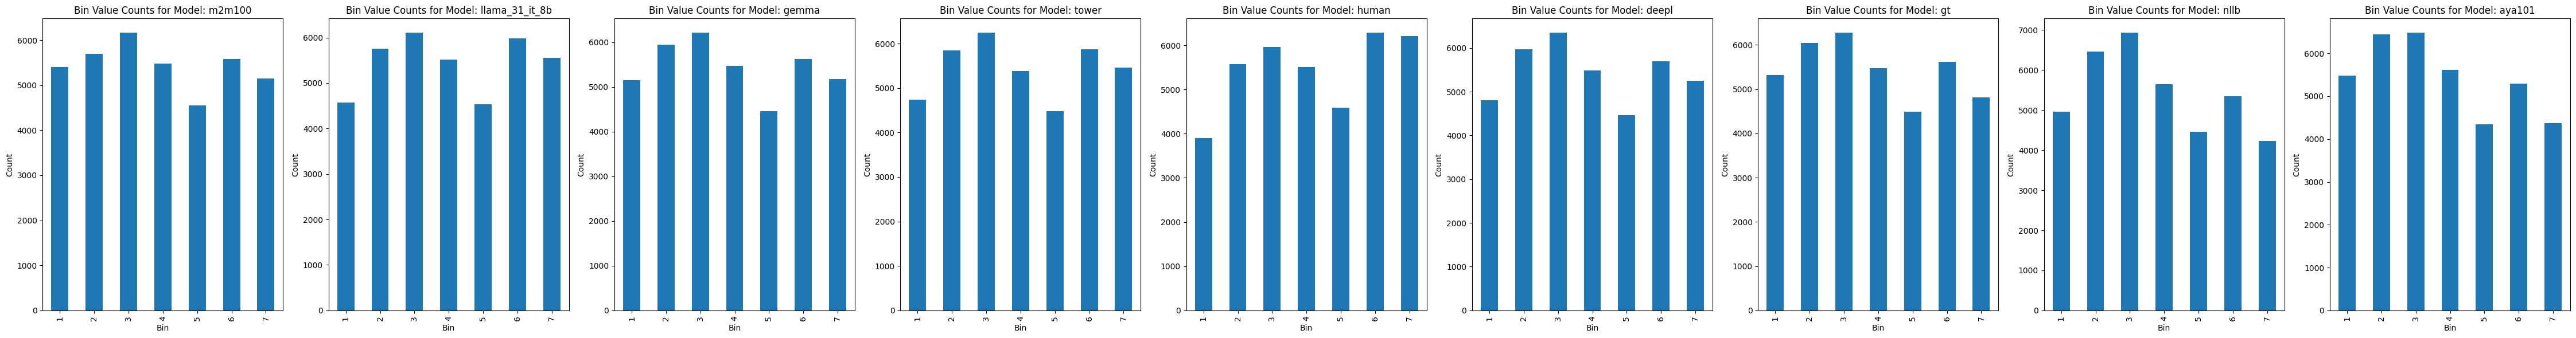

In [7]:
models_list = get_models_list()
num_models = len(models_list)

# Create a figure with a 1xN grid of subplots, where N is the number of models
fig, axes = plt.subplots(1, num_models, figsize=(5 * num_models, 6))  # Adjust size as needed

# Iterate over the models and corresponding axes
for i, (model_name, ax) in enumerate(zip(models_list, axes)):

    # Plot the value counts of the 'bin' column as a bar plot
    model_dfs[model_name]["bin"].value_counts().sort_index().plot(kind='bar', ax=ax)

    # Set the title and labels for each subplot
    ax.set_title(f'Bin Value Counts for Model: {model_name}')
    ax.set_xlabel('Bin')
    ax.set_ylabel('Count')

# Adjust the spacing between plots
plt.tight_layout()

# Display the plots
plt.show()


In [8]:
def pos_feature_df(df, pos):
    df2 = pd.DataFrame({
        "bin": _labels,
        "freq_mean": np.nan,
        "margin_of_error": np.nan,
        # "num_feature": np.nan,
        # "num_sents": np.nan
    })
    for bn, df_bin in tqdm(df.groupby("bin", observed=True)):
        # source = []
        # num_sents = 0
        # for e, row in df_bin.iterrows():
        #     source.extend(row["pos"])
        #     num_sents += 1
        source = df_bin
        num_sents = len(df_bin)
        n = len(source)
        freqs = []
        for i in range(1000):
            sample = df_bin.sample(n=n, replace=True)
            freqs.append(np.sum(sample["pos"].apply(lambda x: x.count(pos) / num_sents)))
        freqs = np.array(freqs)
        mean = np.mean(freqs)
        std_dev = np.std(freqs, ddof=1)
        Z = 1.96
        margin_of_error = Z * std_dev
        df2.loc[df2["bin"] == bn, "freq_mean"] = mean
        df2.loc[df2["bin"] == bn, "margin_of_error"] = margin_of_error
    return df2

# def pos_feature_df_stack(df, pos):
#     df = pos_feature_df(df, pos)
#     human = pos_feature_df(model_dfs["human"], pos)
#     df["human_feature_ratio"] = human["feature_ratio"]
#     return df

In [9]:
pos_feature_df(add_bin_number_to_df(add_word_count_to_df(model_dfs["aya101"])), "PUNCT")

100%|█████████████████████████████████████████████| 7/7 [00:09<00:00,  1.40s/it]


,bin,freq_mean,margin_of_error
0,1,1.093322,0.011036
1,2,1.231608,0.012034
2,3,1.356567,0.014122
3,4,1.456906,0.015914
4,5,1.467989,0.020023
5,6,1.333940,0.020434
6,7,1.630243,0.022810


In [22]:
def nice_name(name):
    m = {
        "gt": "Google Translate",
        "llm": "LLamaX-3.1-8B-Alpaca",
        "m2m100": "M2M-100-418M",
        "madlad": "MADLAD-400-3B-MT",
        "nllb": "NLLB-600M",
        "aya101": "Aya-101-13B",
        "deepl": "DeepL",
        "tower": "TowerInstruct-7B-v0.2",
        "human": "Human",
        "llama_31_it_8b": "Llama-3.1-8B-Instruct",
        "gemma": "Gemma-7B"
    }
    return m[name]

In [11]:
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
# set the font size of the text in the plot
plt.rcParams.update({'font.size': 17 - 7})
plt.rcParams.update({'axes.labelsize': 21 - 7})
plt.rcParams.update({'xtick.labelsize': 18 - 7})
plt.rcParams.update({'ytick.labelsize': 18 - 7})
plt.rcParams.update({'legend.fontsize': 17 - 7})

In [12]:
from collections import Counter
pos = []
for model in model_dfs:
    for e, row in model_dfs[model].iterrows():
        pos.extend(row["pos"])
pos_list = list(set([p for (p, freq) in Counter(pos).most_common(10)]) - {"PROPN"})

In [13]:
models_list = ['m2m100', 'deepl', 'gt', 'nllb', 'llama_31_it_8b', 'gemma', 'tower', 'aya101', 'human']
model_colors = [
    "#1e90ff","#4169e1","#6495ed","#87cefa",
    "#006400","#98fb98","#3cb371","#32cd32",
    '#7f7f7f'
]

In [16]:
for idx in range(len(pos_list)):
    pos = pos_list[idx]
    print(f"({idx}/{len(pos_list)-1}) POS:", pos)
    for i, model_name in enumerate(models_list):
        df = pos_feature_df(model_dfs[model_name], pos)
        df.to_csv(f"{pos}_{model_name}_ci.csv")

(0/8) POS: ADV


100%|█████████████████████████████████████████████| 7/7 [00:08<00:00,  1.22s/it]


(1/8) POS: DET


100%|█████████████████████████████████████████████| 7/7 [00:08<00:00,  1.18s/it]


(2/8) POS: ADJ


100%|█████████████████████████████████████████████| 7/7 [00:08<00:00,  1.20s/it]


(3/8) POS: NOUN


100%|█████████████████████████████████████████████| 7/7 [00:08<00:00,  1.23s/it]


(4/8) POS: VERB


100%|█████████████████████████████████████████████| 7/7 [00:08<00:00,  1.23s/it]


(5/8) POS: PRON


100%|█████████████████████████████████████████████| 7/7 [00:08<00:00,  1.23s/it]


(6/8) POS: AUX


100%|█████████████████████████████████████████████| 7/7 [00:08<00:00,  1.23s/it]


(7/8) POS: PUNCT


100%|█████████████████████████████████████████████| 7/7 [00:08<00:00,  1.18s/it]


(8/8) POS: ADP


100%|█████████████████████████████████████████████| 7/7 [00:08<00:00,  1.28s/it]


In [20]:
models_list = ['m2m100', 'deepl', 'gt', 'nllb', 'llama_31_it_8b', 'gemma', 'tower', 'aya101', 'human']
model_colors = [
    "#1e90ff","#4169e1","#6495ed","#87cefa",
    "#006400","#98fb98","#3cb371","#32cd32",
    '#7f7f7f'
]
markers = ['o', 's', 'D', '^', 'v', 'P', '*', 'X', 'h']

/var/folders/8x/yjwm95z12l924_zksrf1l8cw0000gn/T/ipykernel_79639/3849345286.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df['bin'].apply(bin_num_to_label), rotation=0, ha="center", fontsize=14)
/var/folders/8x/yjwm95z12l924_zksrf1l8cw0000gn/T/ipykernel_79639/3849345286.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df['bin'].apply(bin_num_to_label), rotation=0, ha="center", fontsize=14)
/var/folders/8x/yjwm95z12l924_zksrf1l8cw0000gn/T/ipykernel_79639/3849345286.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df['bin'].apply(bin_num_to_label), rotation=0, ha="center", fontsize=14)
/var/folders/8x/yjwm95z12l924_zksrf1l8cw0000gn/T/ipykernel_79639/3849345286.py:52: Us

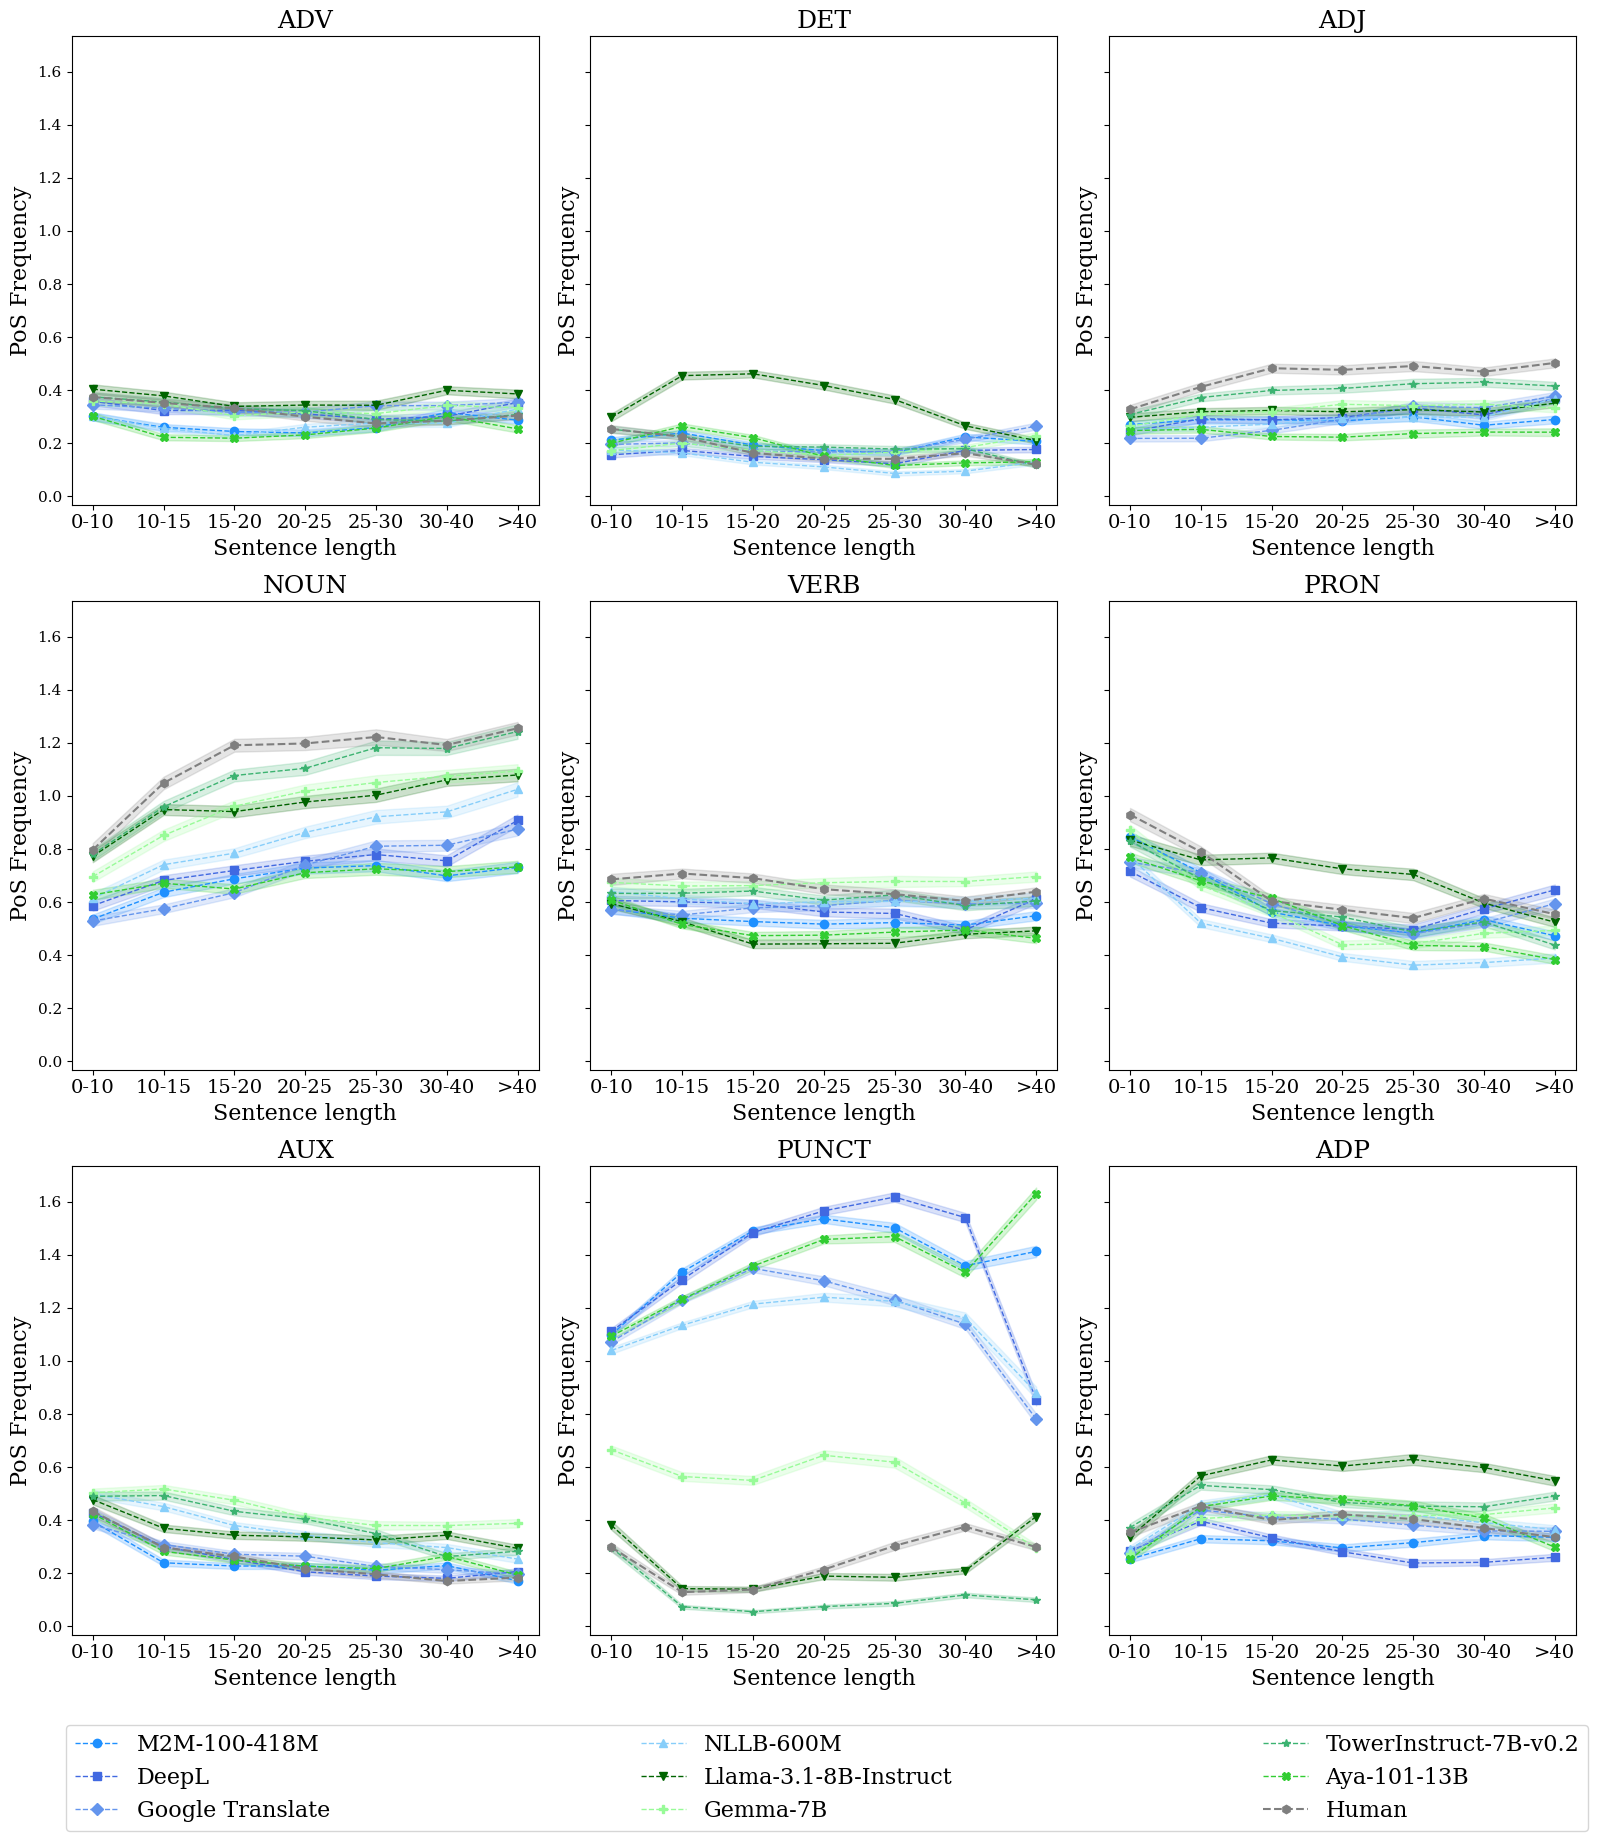

In [23]:
# Create a figure for all subplots
n_rows = 3
n_cols = 3
fig, axs = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 6), sharey=True)
axs = axs.flatten()  # Flatten the array of axes for easier indexing

# igp through each POS and plot
for idx in range(len(pos_list)):
    pos = pos_list[idx]
    ax = axs[idx]  # Get the corresponding subplot axis for each POS
    
    # Plot each model's data in its respective subplot
    for i, model_name in enumerate(models_list):
        if model_name == "human":
            linewidth = 1.5
        else:
            linewidth = 1 
        linestyle = "--"
        
        df = pd.read_csv(f"{pos}_{model_name}_ci.csv")
        
        # Calculate the upper and lower bounds of the standard deviation
        lower_bound = df['freq_mean'] - df['margin_of_error']
        upper_bound = df['freq_mean'] + df['margin_of_error']
        
        # Plot the line for the mean frequency
        ax.plot(
            df['bin'].apply(bin_num_to_label),  # X values
            df['freq_mean'],                    # Y values (mean)
            label=f'{model_name}',              # Label for the plot
            color=model_colors[i],                    # Line color
            marker=markers[i],                  # Marker style
            linestyle=linestyle,                # Line style
            linewidth=linewidth                 # Line width
        )
        
        # Plot the shaded area representing the standard deviation
        ax.fill_between(
            df['bin'].apply(bin_num_to_label),  # X values
            lower_bound,                        # Lower bound
            upper_bound,                        # Upper bound
            color=model_colors[i],                    # Fill color
            alpha=0.2                           # Transparency of the shaded area
        )
    
    # Set title and labels for each POS subplot with increased font size
    ax.set_title(f'{pos}', fontsize=18)
    ax.set_ylabel('PoS Frequency', fontsize=16)
    ax.set_xlabel('Sentence length', fontsize=16)
    
    # Rotate x-axis labels for this subplot and adjust font size
    ax.set_xticklabels(df['bin'].apply(bin_num_to_label), rotation=0, ha="center", fontsize=14)

# Remove any extra axes that are not used
for idx in range(len(pos_list), len(axs)):
    fig.delaxes(axs[idx])

# Get the handles and labels for the legend
handles, labels = axs[0].get_legend_handles_labels()

# Create a legend below the subplots for all rows with larger font size and two rows
fig.legend(handles, list(map(nice_name, labels)), 
           loc='upper center', 
           bbox_to_anchor=(0.52, -0.005), 
           ncol=3, 
           prop={'size': 16}, 
           columnspacing=14)

# Adjust layout and set the main title for the figure
fig.tight_layout(rect=[0, 0, 1, 0.95])  # Space for the main title

# Show the entire figure
plt.savefig(f'ig_pos_distribution.png', bbox_inches='tight')
plt.show()
